# Deep Convolution Generative Adversarial Network (DCGAN)

This solution was inspired by the solution developed in:

https://medium.com/@manoharmanok/implementing-dcgan-in-pytorch-using-the-celeba-dataset-a-comprehensive-guide-660e6e8e29d2

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader, Subset

import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

In [20]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if not torch.cuda.is_available():
    print("WARNING: CUDA not available. Running on CPU.")

In [21]:
# Set up variables
image_size = 64         # Desired size of input images
batch_size = 128        # Batch size during training

In [22]:
# Normalise data
transform_train = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [23]:
# Create train data
train_data = CelebA(root='C:/Users/Jacqu/Downloads/data/celeba', 
                    split='train', download=False, transform=transform_train)

Create a random subset of data so that we can ensure our model works before moving onto the full dataset:

In [24]:
# Create random indices for train and test datasets
train_indices = torch.randperm(len(train_data))[:1000]

# Create random subset of data
train_data = Subset(train_data, train_indices)

print(f"Num Train Subset Samples: {len(train_data)}")

Num Train Subset Samples: 1000


In [25]:
# Create DataLoader for train and test datasets
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

To make sure this worked, let's show a random set of images from the dataloader:

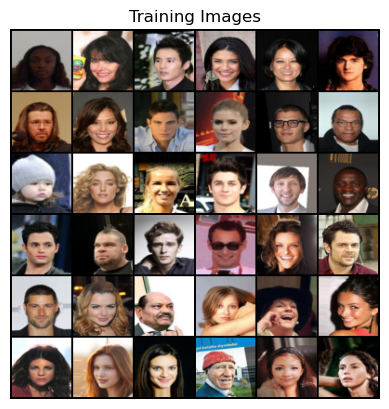

In [26]:
# Get a random batch of images
sample_batch = next(iter(train_loader))

# Make grid from the batch and normalise the images
# Need to permute since PyTorch tensors assume image channel is first dimensions
# but matplotlib assumes it is the third dimension
grid = vutils.make_grid(sample_batch[0][:36], normalize=True, nrow=6).permute(1,2,0)

plt.axis("off")
plt.title("Training Images")

# Convert to numpy array and plot
plt.imshow(np.array(grid))

## How a GAN works:

![Alt text](image-1.png)

So, the architecture of a GAN consists of two main components: the generator and the discriminator.

### The Generator
The generator takes random noise as input and gradually transforms it into fake images that resembles the training data. It does this through a series of layers, including:
- Transposed convolutions
- Batch normalisation
- Activation functions
These layers allow the generator to learn complex patterns and structures, resulting in it - over a number of epochs - being able to generate samples that capture the details of real data.

### The Discriminator
The discriminator acts as a binary classifier, all it needs to do is distinguish between real and generated samples. Similar to the generator, it receives input samples and passes them through:
- Convolutional layers
- Batch normalisation
- Activation functions
It's role is essentially just assessing the authenticity of samples and provide feedback (in terms of loss) to the generator.

Through an adversarial training process, these two models continuously compete and improve their performance, leading to the generation of better and more realistic samples.

In [ ]:
# Hyperparameters
learning_rate = 0.0001  # Learning rate for model during optimisation
image_channels = 3      # Number of channels in input images (3 for RGB)
z_dim = 100             # Size of z latent space (i.e. size of generator input)
num_epochs = 10         # Number of training epochs
features_disc = 64      # Number of features in discriminator's convolutional layers
features_gen = 64       # Number of features in generator's convolutional layers

## Generator Network

![Alt text](image-2.png)

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            self._block(z_dim, features_g * 16, 4, 1, 0),
            self._block(features_g * 16, features_g * 8, 4, 2, 1),
            self._block(features_g * 8, features_g * 4, 4, 2, 1),
            self._block(features_g * 4, features_g * 2, 4, 2, 1),
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.net(x)

## Discriminator Network

![Alt text](image-3.png)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.disc(x)